In [19]:
import cv2
from pathlib import Path
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imutils

%reload_ext autoreload
%autoreload 0
from main import getROIFromVideo, cropWithROI, getOutputVidFrameSize, CalibWindow, getFrameFromVid

# Crop

In [3]:
vidPath = Path("data/screw/screw.mp4")
crop_roi = getROIFromVideo(str(vidPath))
cv2.destroyAllWindows()

In [4]:
# import pickle
# f = open("temp_crop.pkl", "wb")
# pickle.dump(crop_roi, f)

# f = open("temp.pkl", "rb")
# pickle.load(f)

# Track

In [20]:
VID_PATH = Path("data/screw/screw.mp4")
OUTPUT_VID_PATH = vidPath.parent/(vidPath.stem+"_output.mp4")
OUTPUT_HEIGHT = 800

IMSHOW_FLAG = True
WRITE_FLAG = True

cap = cv2.VideoCapture(str(vidPath))
fps = cap.get(cv2.CAP_PROP_FPS)

pipeline = lambda frame: cropWithROI(frame, crop_roi)
frameWidth, frameHeight = getOutputVidFrameSize(str(VID_PATH), pipeline, OUTPUT_HEIGHT)
out = cv2.VideoWriter(str(OUTPUT_VID_PATH), cv2.VideoWriter_fourcc(*"mp4v"), cap.get(cv2.CAP_PROP_FPS), (frameWidth,frameHeight))

totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
frameCount = 0
startTime = time.time()
saveFrames = []
saveCnts = []

ret, frame = cap.read()
while ret:
    if frameCount % 100 == 0 and frameCount != 0:
        elapsedTime = time.time()-startTime
        estTimeLeft = (totalFrames-frameCount)/frameCount*elapsedTime
        print(f"Frame {frameCount} out of {round(totalFrames)}.")
        print(f"\tTime taken: {round(elapsedTime)}s. Est. time left: {round(estTimeLeft)}s")

    frame = pipeline(frame)
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    (frame_h,frame_s,frame_v) = cv2.split(frame_hsv)

    ret, th = cv2.threshold(frame_h, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    cnts, hierarchy = cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    cnt = max(cnts, key=cv2.contourArea) 
    cv2.drawContours(frame, [cnt], -1, (255, 0, 0), 1)

    saveFrames.append(frameCount)
    saveCnts.append(cnt)
    
    frame = imutils.resize(frame, height=OUTPUT_HEIGHT)

    if WRITE_FLAG:
        out.write(frame)

    if IMSHOW_FLAG:
        cv2.imshow("Detections", frame)
        key = cv2.waitKey(1)
        if key == ord('q') or key == ord('Q'):
            break
 
    ret, frame = cap.read()
    frameCount += 1

cv2.destroyAllWindows()
out.release()
cap.release()

Frame 100 out of 257.
	Time taken: 2s. Est. time left: 3s
Frame 200 out of 257.
	Time taken: 4s. Est. time left: 1s


In [6]:
# import pickle
# f = open("temp_track.pkl", "wb")
# pickle.dump([saveFrames, saveCnts], f)

# f = open("temp.pkl", "rb")
# pickle.load(f)

# Get Calibration Scale

In [8]:
VID_PATH = Path("data/screw/screw.mp4")
pipeline = lambda frame: cropWithROI(frame, crop_roi)

frame = getFrameFromVid(str(VID_PATH), 1)
img_rgb = pipeline(frame)
calibLength = 1

CalibWin = CalibWindow("Calibration", img_rgb)
CalibWin.displayWindow()
calibPoints = CalibWin.calibPoints
scale = CalibWin.getCalibScale(calibLength)
key = cv2.waitKey(0)
print(f"Scale is {scale} pixels per metre")

Scale is 80.02499609497022 pixels per metre


# Write to CSV

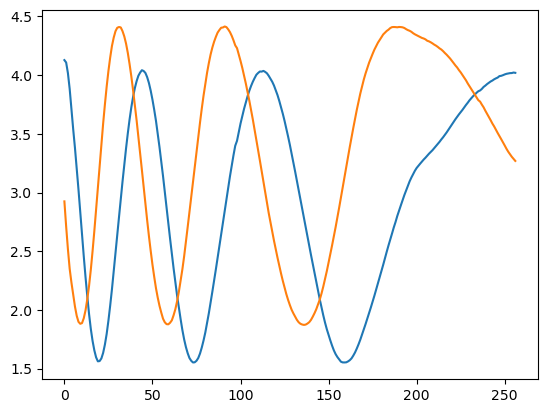

In [18]:
xs, ys = [], []

for c in saveCnts:
    M = cv2.moments(c)
    xs.append(M["m10"] / M["m00"])
    ys.append(M["m01"] / M["m00"])

xs = np.array(xs)/scale
ys = np.array(ys)/scale

plt.plot(saveFrames, xs)
plt.plot(saveFrames, ys)

In [16]:
csvPath = Path(VID_PATH).parent / (Path(VID_PATH).stem + ".csv")
df = pd.DataFrame([saveFrames, xs, ys]).T
df.to_csv(csvPath, index=None, header=["frame","x","y"])

# Get Calibration Scale

In [ ]:
# if getCalib: # Assume camera does not move between videos
#     # Set calibration length
#     CalibWin = CircleCalibWindow("Calibration", frame_trunc)
#     CalibWin.displayWindow()
#     scale = CalibWin.getCalibScale(calibRadius)
